# A look at high energy data 

In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import gc

module_dir = os.path.abspath('../src/')
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi, merge_hdfs_multi_reco, merge_hdfs_multi_reco_event
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf

import analysis_functions as af
import stats
import utility as ut

#Can be removed later
import importlib
importlib.reload(af)
from sklearn.cluster import DBSCAN
#

In [2]:
run_number = 15607
folderdata = [f"/scratch/torellis/NEXTResoAnalysis/data/{run_number}/trg2"]

In [3]:
df = merge_hdfs_multi(folderdata)

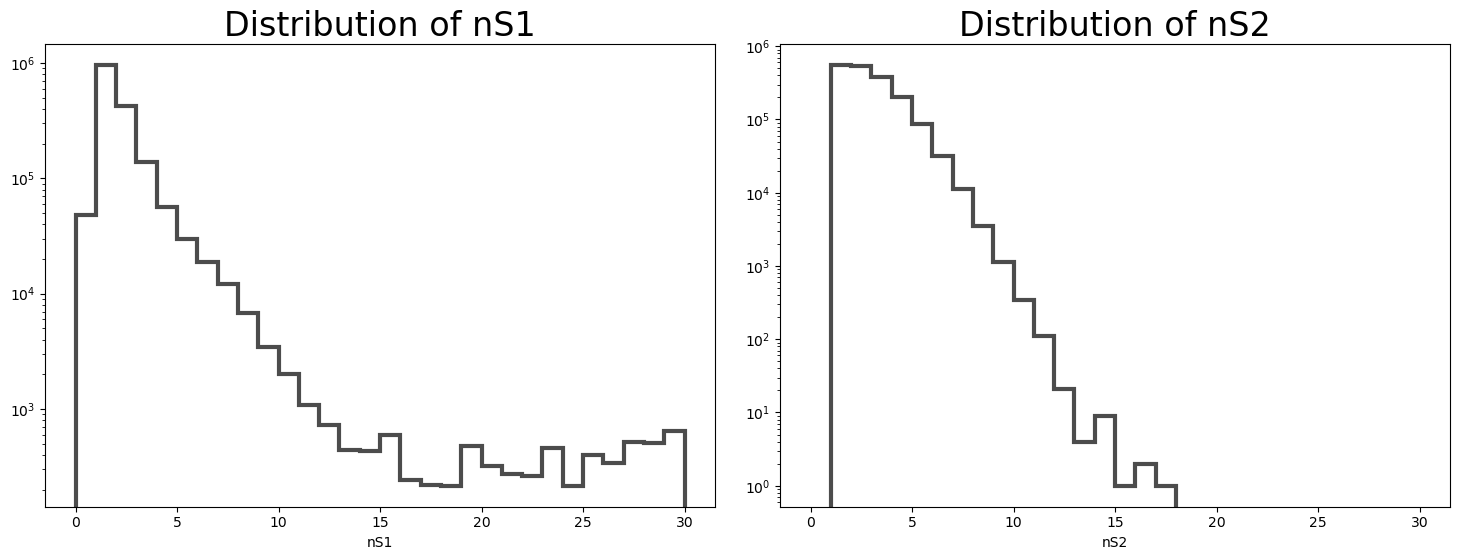

In [4]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
auto_plot_style()

# Plot histogram of df_sel['s1w']
axes[0].hist(df[df['s2_peak']==0]['nS1'], bins=30, range=[0,30], histtype='step', color = color_sequence[0], alpha=0.7)
axes[0].set_xlabel('nS1')
axes[0].set_title('Distribution of nS1')
axes[0].set_yscale('log')

# Plot histogram of df_sel['s1e']
axes[1].hist(df[df['s2_peak']==0]['nS2'], bins=30, range = [0,30], histtype='step',color = color_sequence[0], alpha=0.7)
axes[1].set_xlabel('nS2')
axes[1].set_yscale('log')
axes[1].set_title('Distribution of nS2')

# Adjust layout for better spacing
plt.tight_layout()

In [5]:
df = df.dropna()
df.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

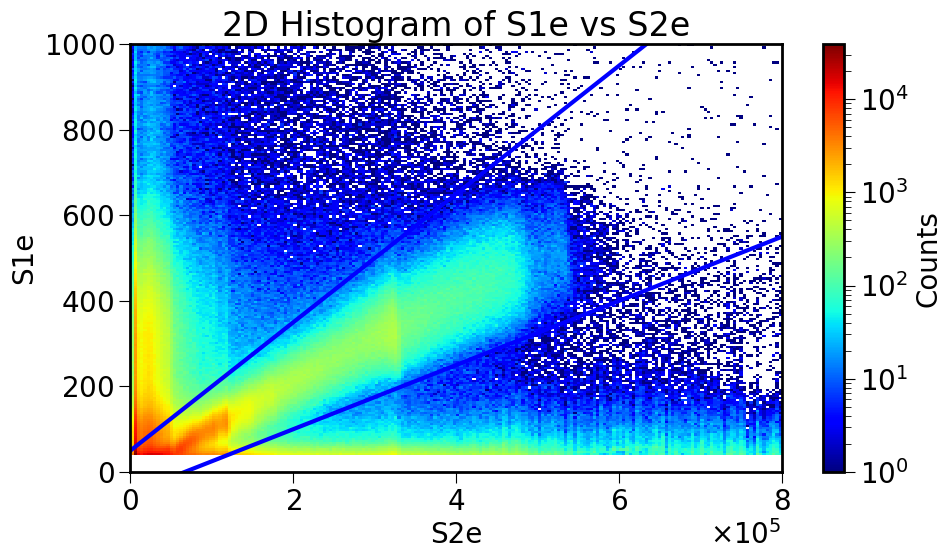

In [6]:
# Define histogram bins
x = df['S1e']
y = df['S2e']

xrange = (0,.8e6)
yrange = (0,1000)

# Compute 2D histogram
H, xedges, yedges = np.histogram2d(y, x, bins=(200,200), range= ( xrange, yrange) )

# Mask zero-count bins
H = np.where(H == 0, np.nan, H)

lineup = ut.line_from_points( 0.,50.,0.4e6,650 )
linedown = ut.line_from_points(0.2e6,100,0.6e6,400)

x_vals = np.linspace(0, 1e6, 1000)

# Evaluate the line at each x
y_vals = linedown(x_vals)

# Plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, H.T, cmap='jet',norm = LogNorm())
plt.plot(x_vals, lineup(x_vals), label='linedown', color='blue')
plt.plot(x_vals, linedown(x_vals), label='linedown', color='blue')
plt.colorbar(label='Counts')
plt.xlabel('S2e')
plt.ylabel('S1e')
plt.xlim(xrange)
plt.ylim(yrange)
plt.title('2D Histogram of S1e vs S2e')
plt.tight_layout()
plt.show()

In [7]:
df_Sprop = df[(df['S1e'] >= linedown(df['S2e'])) & (df['S1e'] <= lineup(df['S2e']))]
print(f"NEvent filtered road : {len(np.unique(df_Sprop['event']))}")
print(f"eff:{(len(np.unique(df_Sprop['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1215948
eff:97.72%


In [8]:
df_Sprop_single_s1s2 = df_Sprop.groupby('time').filter(lambda x: (x['s1_peak'].count() == 1) & (x['s2_peak'].count() == 1))

print(f"NEvent filtered road : {len(np.unique(df_Sprop_single_s1s2['event']))}")
print(f"eff:{(len(np.unique(df_Sprop_single_s1s2['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 807661
eff:64.91%


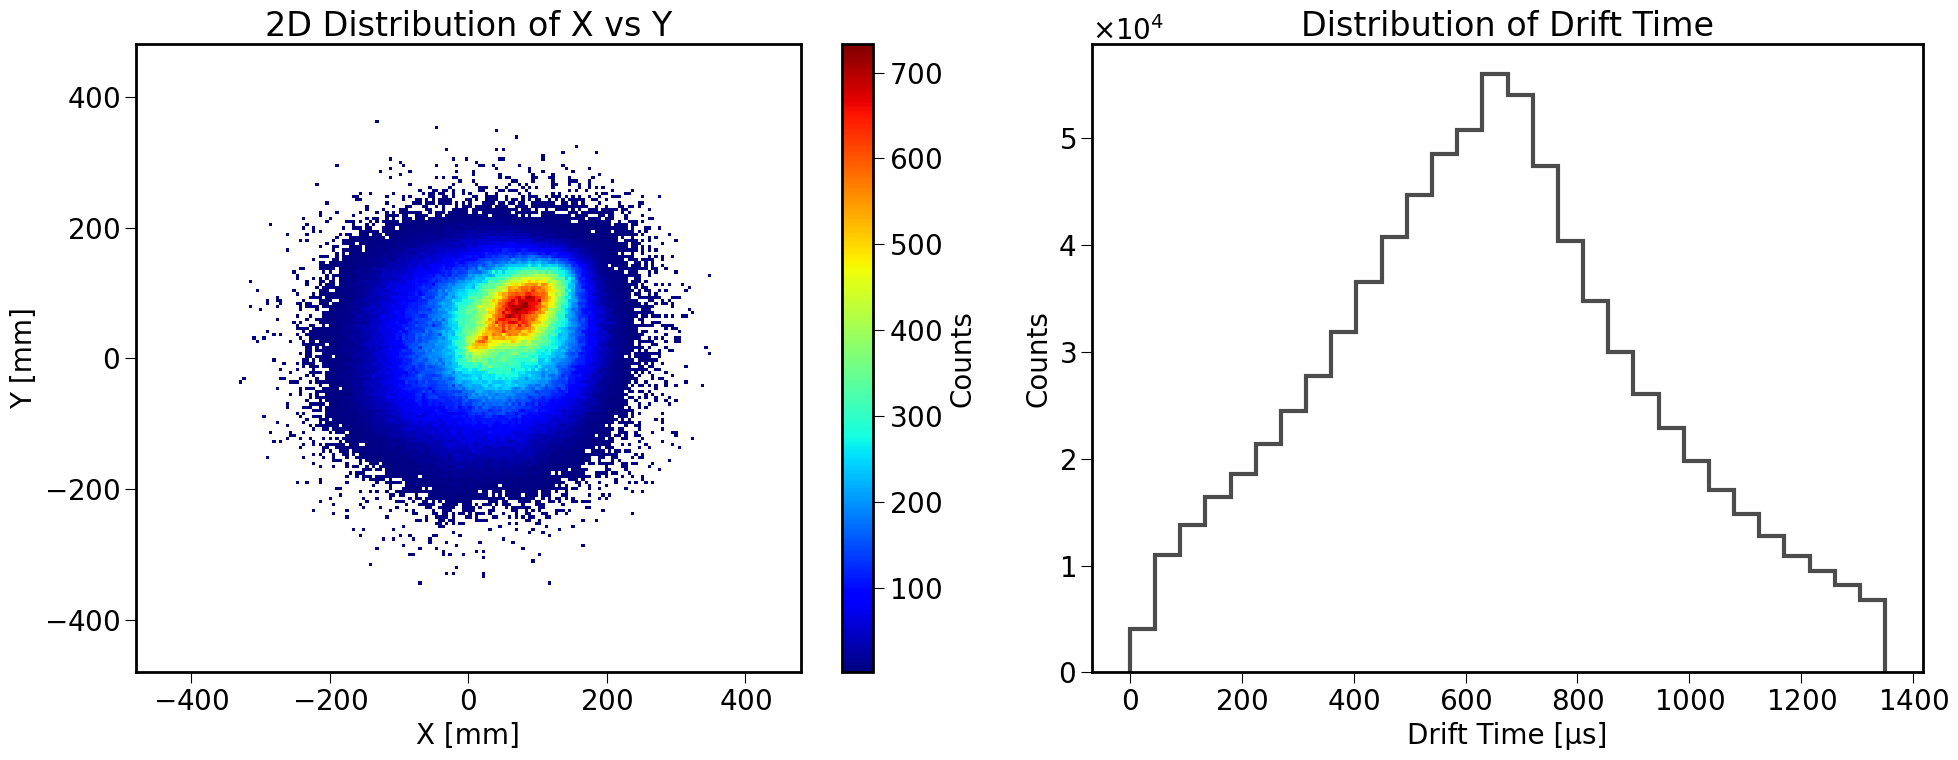

In [9]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
auto_plot_style()  # Assuming this sets fonts and colors

# --- 2D Histogram of X vs Y ---
H, xedges, yedges = np.histogram2d(
    df_Sprop_single_s1s2['X'], df_Sprop_single_s1s2['Y'],
    bins=(200, 200), range=((-480, 480), (-480, 480))
)
H = np.where(H == 0, np.nan, H)  # Mask zero counts

pcm = axes[0].pcolormesh(xedges, yedges, H.T, cmap='jet')
axes[0].set_xlabel('X [mm]')
axes[0].set_ylabel('Y [mm]')
axes[0].set_title('2D Distribution of X vs Y')

# Add colorbar
fig.colorbar(pcm, ax=axes[0], label='Counts')

# --- Histogram of Drift Time (DT) ---
axes[1].hist(
    df_Sprop_single_s1s2['DT'],
    bins=30, range=(0, 1350),
    histtype='step',
    color=color_sequence[0],
    alpha=0.7
)
axes[1].set_xlabel('Drift Time [μs]')
axes[1].set_ylabel('Counts')
axes[1].set_title('Distribution of Drift Time')

# Final layout
plt.tight_layout()
plt.show()

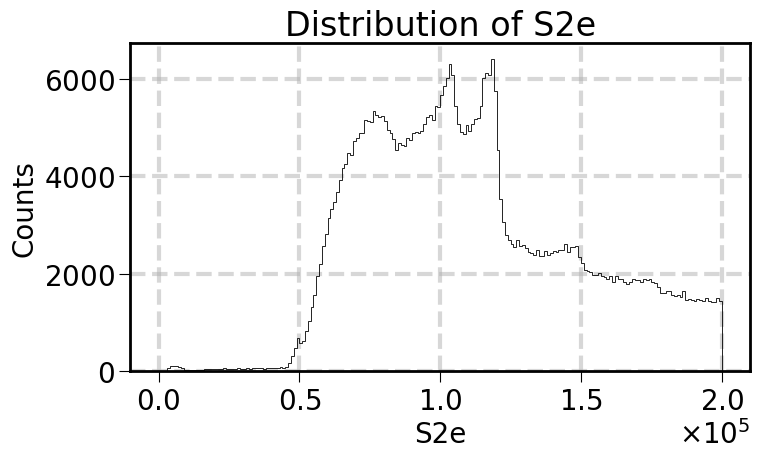

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(df_Sprop_single_s1s2['S2e'], bins=200, range=(0,2e5), histtype='step',linewidth = .6)
plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('Distribution of S2e')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
kr_map = af.load_kr_map('../db/kr_maps/map_run15586.npz')

In [12]:
df_Sprop_single_s1s2_coor = af.correct_S2e(df_Sprop_single_s1s2, kr_map, rmax=400.0, zmax=1350.0)

In [13]:
df_Sprop_single_s1s2_coor[['S2e','Epes','corrections']]

S2e           Epes  corrections
1        318437.625000  324829.291643     0.980323
3         63167.593750   64621.915509     0.977495
7         89424.937500   90713.510243     0.985795
8        104673.710938  105056.384592     0.996357
18        75205.710938   75302.614212     0.998713
...                ...            ...          ...
4339857   76394.093750   75814.321612     1.007647
4339858  111262.953125  115664.299185     0.961947
4339868  458101.250000  452712.640081     1.011903
4339871   93569.367188   93634.542603     0.999304
4339875  457738.437500  468250.713196     0.977550

[791653 rows x 3 columns]

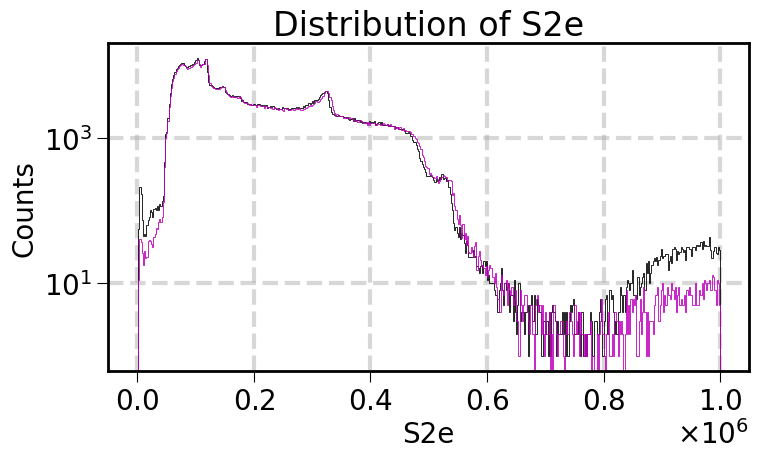

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(df_Sprop_single_s1s2['S2e'], bins=500, range=(0,1e6), histtype='step',linewidth = .6)
plt.hist(df_Sprop_single_s1s2_coor['Epes'], bins=500, range=(0,1e6), histtype='step',linewidth = .6)
plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('Distribution of S2e')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
ev_list = df_Sprop_single_s1s2[(df_Sprop_single_s1s2['S2e']>0.45e6) & (df_Sprop_single_s1s2['S2e']<0.65e6)]['event'].unique()


In [16]:
ev_list


array([    159,     432,    2140, ..., 3816402, 3816689, 3816717])

In [17]:
del df,df_Sprop,df_Sprop_single_s1s2, df_Sprop_single_s1s2_coor
gc.collect()

52383

In [18]:
folderdata_hits = [f"/scratch/torellis/NEXTResoAnalysis/data/{run_number}/trg2/ldc1/",f"/scratch/torellis/NEXTResoAnalysis/data/{run_number}/trg2/ldc2/"]
df_pe_peak = merge_hdfs_multi_reco_event(folderdata_hits,ev_list)

In [19]:
df_pe_peak

event          time  npeak      Xpeak      Ypeak  nsipm        X  \
0             869  1.752993e+09     32  67.658760  78.877883      1 -482.625   
1             869  1.752993e+09     32  67.658760  78.877883      1  -19.125   
2             869  1.752993e+09     32  67.658760  78.877883      1  351.075   
3             869  1.752993e+09     32  67.658760  78.877883      1 -126.975   
4             869  1.752993e+09     32  67.658760  78.877883      1   -3.575   
...           ...           ...    ...        ...        ...    ...      ...   
27772431  3816717  1.753079e+09      7  67.369951  30.842208      1   73.175   
27772432  3816717  1.753079e+09      7  67.369951  30.842208      1   88.725   
27772433  3816717  1.753079e+09      7  67.369951  30.842208      1 -281.475   
27772434  3816717  1.753079e+09      7  67.369951  30.842208      1 -359.225   
27772435  3816717  1.753079e+09      7  67.369951  30.842208      1  351.075   

                Y  Xrms  Yrms            Z         Q          E   Qc  \
0         260.975   0.0   0.0   484.545750  5.194547   0.699879 -1.0   
1        -433.275   0.0   0.0   484.545750  6.715086   0.904746 -1.0   
2        -217.075   0.0   0.0   484.545750  5.698934   0.767836 -1.0   
3         399.425   0.0   0.0   489.781875  5.224109   0.156531 -1.0   
4         414.975   0.0   0.0   489.781875  8.781216   0.263113 -1.0   
...           ...   ...   ...          ...       ...        ...  ...   
27772431   60.325   0.0   0.0  1269.503000  5.945141  82.452099 -1.0   
27772432   13.675   0.0   0.0  1269.503000  6.643796  92.141622 -1.0   
27772433 -185.975   0.0   0.0  1273.227000  5.106070  29.633648 -1.0   
27772434  137.575   0.0   0.0  1273.227000  5.566214  32.304146 -1.0   
27772435 -356.025   0.0   0.0  1273.227000  6.098174  35.391438 -1.0   

                    Ec  track_id   Ep  
0                  NaN        -1 -1.0  
1         5.550780e-06        -1 -1.0  
2         4.310546e-06        -1 -1.0  
3         9.188695e-07        -1 -1.0  
4         1.543880e-06        -1 -1.0  
...                ...       ...  ...  
27772431  4.313831e-04        -1 -1.0  
27772432  4.869077e-04        -1 -1.0  
27772433  1.633023e-04        -1 -1.0  
27772434  1.868839e-04        -1 -1.0  
27772435           NaN        -1 -1.0  

[27772436 rows x 17 columns]

In [20]:
df_pe_peak = df_pe_peak[(df_pe_peak['Z']>0) & (df_pe_peak['Z']<1500)]

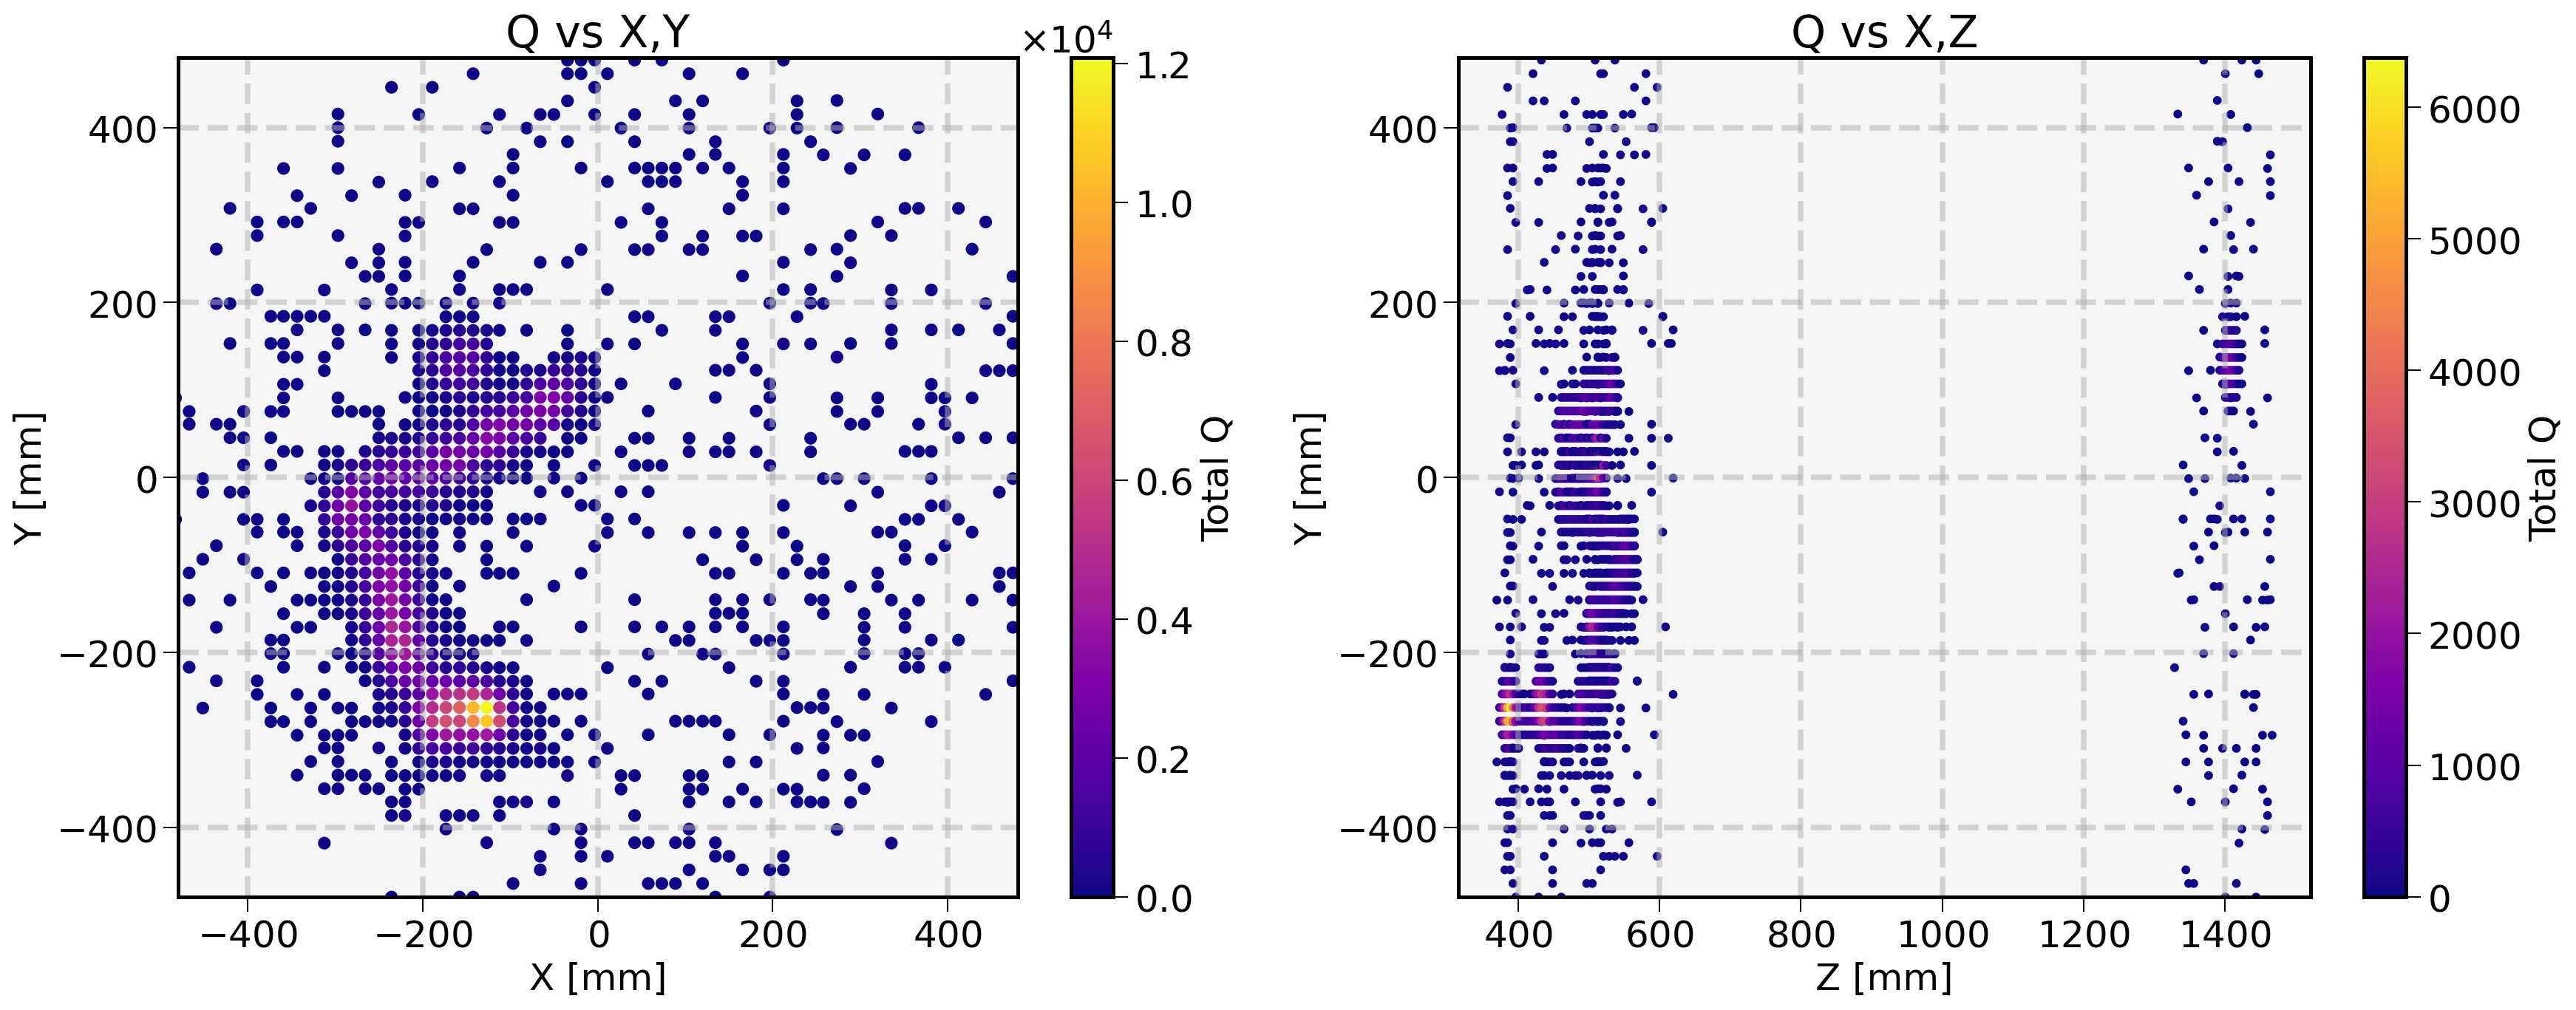

In [62]:
ev_list = df_pe_peak['event'].unique()
df_reco_event = df_pe_peak[df_pe_peak['event'] == ev_list[21]]

# Binning setup
xbins = ybins = 250
zbins = 100
xrange = (-480, 480)
yrange = (-480, 480)
zrange = (0, 1350)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=180)

# Q vs (X,Y)
df_grouped = df_reco_event.groupby(['X', 'Y'], as_index=False)['E'].sum()
sc0 = axes[0].scatter(df_grouped['X'], df_grouped['Y'], c=df_grouped['E'], cmap='plasma', s=15, marker='o')
axes[0].set_title("Q vs X,Y")
axes[0].set_xlabel("X [mm]")
axes[0].set_ylabel("Y [mm]")
axes[0].set_xlim(-480,480)
axes[0].set_ylim(-480,480)
axes[0].set_aspect('equal')
axes[0].grid()
axes[0].set_facecolor("whitesmoke")
fig.colorbar(sc0, ax=axes[0], label="Total Q")

# Q vs (X,Z)
df_grouped = df_reco_event.groupby(['Z', 'Y'], as_index=False)['E'].sum()
sc1 = axes[1].scatter(df_grouped['Z'], df_grouped['Y'], c=df_grouped['E'], cmap='plasma', s=3, marker='o')
axes[1].set_title("Q vs X,Z")
axes[1].set_xlabel("Z [mm]")
axes[1].set_ylabel("Y [mm]")
axes[1].set_ylim(-480,480)
#axes[1].set_xlim(0,1350)
axes[1].set_facecolor("whitesmoke")
axes[1].grid()
fig.colorbar(sc1, ax=axes[1], label="Total Q")

plt.tight_layout()
plt.show()

In [63]:
# Example scaling
a = 14.55  # XY scale
b = 3.7  # Z scale

# Prepare data
X = df_reco_event[['X', 'Y', 'Z']].values

# Apply anisotropic scaling
X_scaled = X.copy()
X_scaled[:, 0] /= a
X_scaled[:, 1] /= a
X_scaled[:, 2] /= b

# Run DBSCAN with the precomputed distance
db = DBSCAN(eps=2.3, min_samples=5)
labels = db.fit_predict(X_scaled)

# Add labels to your DataFrame
df_reco_event['cluster'] = labels

/tmp/ipykernel_40744/2344412048.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reco_event['cluster'] = labels


In [64]:
df_reco_event

event          time  npeak      Xpeak      Ypeak  nsipm        X  \
74187  30248  1.752994e+09     19 -94.158151 -61.936906      1 -297.025   
74188  30248  1.752994e+09     19 -94.158151 -61.936906      1   -3.575   
74189  30248  1.752994e+09     19 -94.158151 -61.936906      1 -126.975   
74190  30248  1.752994e+09     19 -94.158151 -61.936906      1 -126.975   
74191  30248  1.752994e+09     19 -94.158151 -61.936906      1 -112.425   
...      ...           ...    ...        ...        ...    ...      ...   
77975  30248  1.752994e+09     30 -25.705614  38.780577      1   73.175   
77976  30248  1.752994e+09     30 -25.705614  38.780577      1  165.475   
77977  30248  1.752994e+09     30 -25.705614  38.780577      1  351.075   
77978  30248  1.752994e+09     30 -25.705614  38.780577      1  381.175   
77979  30248  1.752994e+09     30 -25.705614  38.780577      1  490.025   

             Y  Xrms  Yrms            Z         Q           E   Qc        Ec  \
74187 -140.325   0.0   0.0   369.605625  5.541438   22.016265 -1.0  0.000114   
74188 -325.425   0.0   0.0   369.605625  5.431210   21.578326 -1.0  0.000115   
74189 -278.775   0.0   0.0   373.314375  5.501378   92.388070 -1.0  0.000495   
74190 -263.225   0.0   0.0   373.314375  5.264423   88.408735 -1.0  0.000475   
74191 -278.775   0.0   0.0   373.314375  7.301915  122.625604 -1.0  0.000656   
...        ...   ...   ...          ...       ...         ...  ...       ...   
77975  338.225   0.0   0.0  1464.588250  5.780346   -1.436589 -1.0 -0.000008   
77976 -139.825   0.0   0.0  1464.588250  8.395239   -2.086468 -1.0 -0.000011   
77977  368.825   0.0   0.0  1464.588250  5.439982   -1.351998 -1.0       NaN   
77978  -93.675   0.0   0.0  1464.588250  5.010020   -1.245140 -1.0 -0.000007   
77979 -294.825   0.0   0.0  1467.092750  6.135538   -1.859626 -1.0       NaN   

       track_id   Ep  cluster  
74187        -1 -1.0       -1  
74188        -1 -1.0       -1  
74189        -1 -1.0        0  
74190        -1 -1.0        0  
74191        -1 -1.0        0  
...         ...  ...      ...  
77975        -1 -1.0       -1  
77976        -1 -1.0       -1  
77977        -1 -1.0       -1  
77978        -1 -1.0       -1  
77979        -1 -1.0       -1  

[3793 rows x 18 columns]

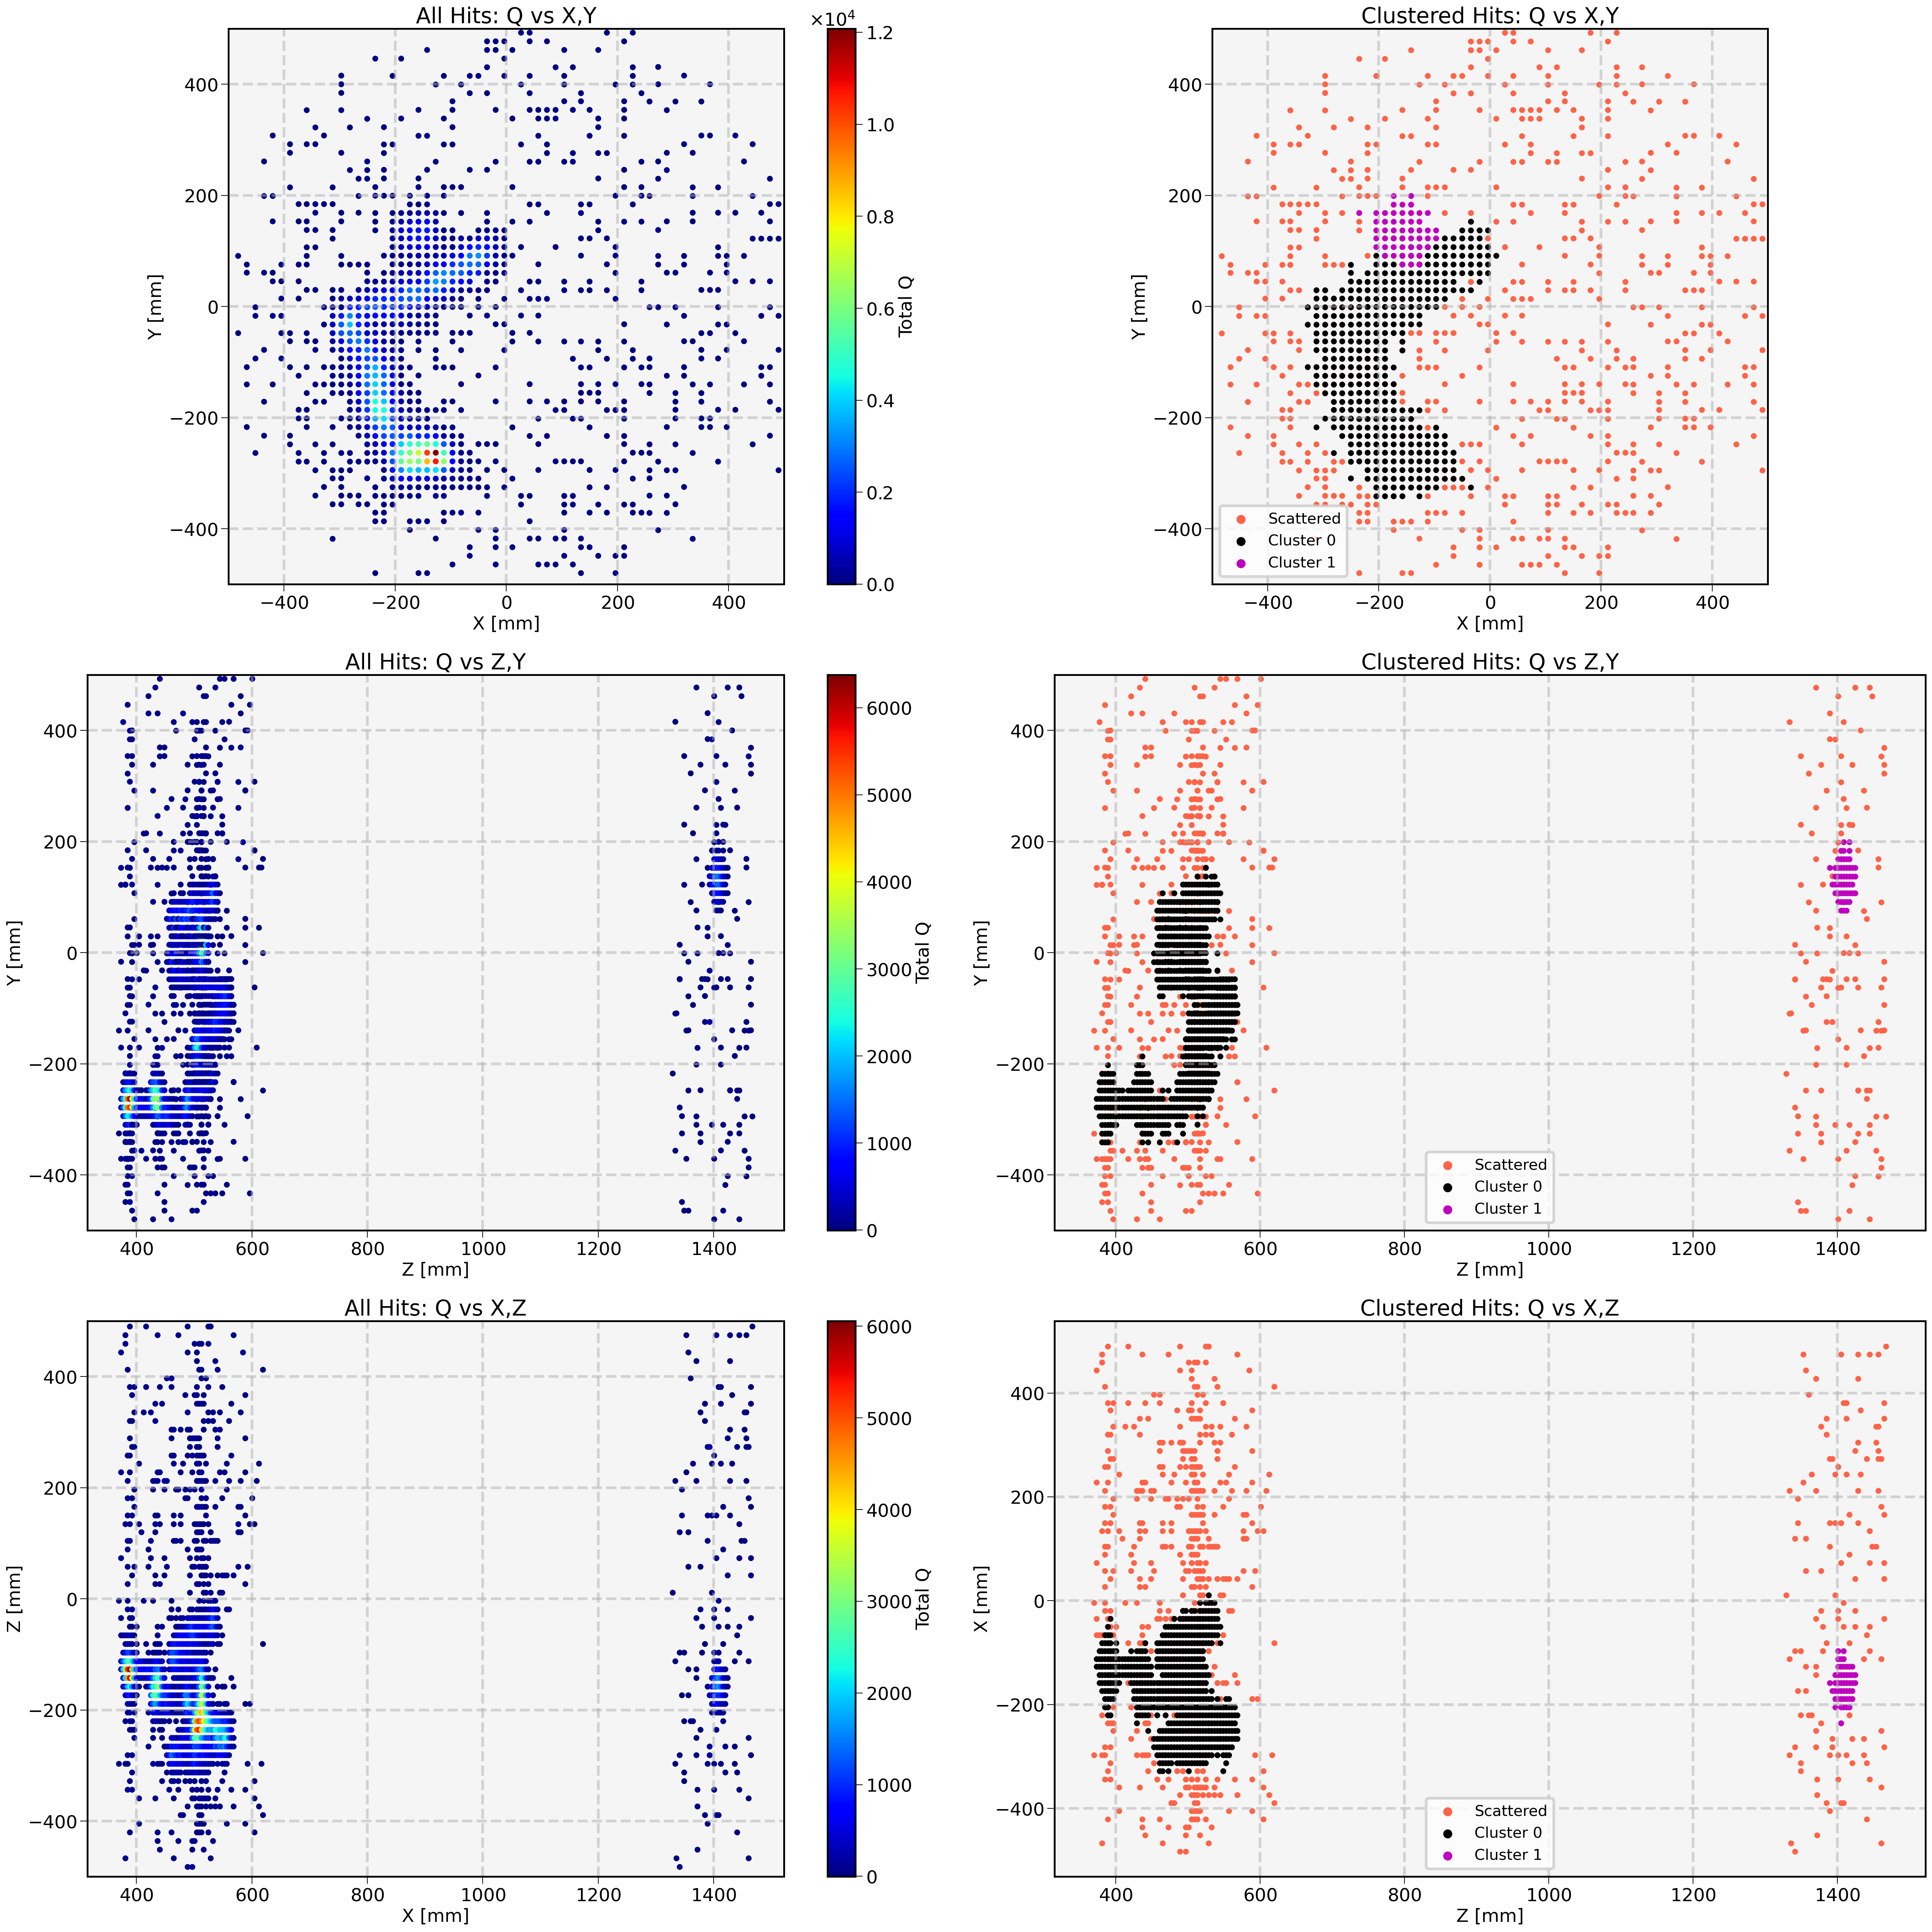

In [65]:
color_sequence = ("k", "m", "g", "b", "r",
                  "gray", "aqua", "gold", "lime", "purple",
                  "brown", "lawngreen", "tomato", "lightgray", "lightpink")

# Group total energy for coloring
df_grouped_xy = df_reco_event.groupby(['X', 'Y'], as_index=False)['E'].sum()
df_grouped_zy = df_reco_event.groupby(['Z', 'Y'], as_index=False)['E'].sum()
df_grouped_xz = df_reco_event.groupby(['X', 'Z'], as_index=False)['E'].sum()

# Group by cluster (includes Scattered)
df_clustered_xy = df_reco_event.groupby(['X', 'Y', 'cluster'], as_index=False)['E'].sum()
df_clustered_zy = df_reco_event.groupby(['Z', 'Y', 'cluster'], as_index=False)['E'].sum()
df_clustered_xz = df_reco_event.groupby(['X', 'Z', 'cluster'], as_index=False)['E'].sum()

# Create 3x2 plot
fig, axes = plt.subplots(3, 2, figsize=(30, 30), dpi=180)

# --- TOP LEFT: All hits X vs Y ---
sc0 = axes[0, 0].scatter(df_grouped_xy['X'], df_grouped_xy['Y'], c=df_grouped_xy['E'],
                         cmap='jet', s=12, marker='o')
axes[0, 0].set_title("All Hits: Q vs X,Y")
axes[0, 0].set_xlabel("X [mm]")
axes[0, 0].set_ylabel("Y [mm]")
axes[0, 0].set_xlim(-500, 500)
axes[0, 0].set_ylim(-500, 500)
axes[0, 0].set_aspect('equal')
axes[0, 0].grid()
axes[0, 0].set_facecolor("whitesmoke")
fig.colorbar(sc0, ax=axes[0, 0], label="Total Q")

# --- TOP RIGHT: Clustered hits X vs Y ---
for cl in sorted(df_clustered_xy['cluster'].unique()):
    cluster_df = df_clustered_xy[df_clustered_xy['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[0, 1].scatter(cluster_df['X'], cluster_df['Y'], s=12, marker='o', label=label, c=color)
axes[0, 1].set_title("Clustered Hits: Q vs X,Y")
axes[0, 1].set_xlabel("X [mm]")
axes[0, 1].set_ylabel("Y [mm]")
axes[0, 1].set_xlim(-500, 500)
axes[0, 1].set_ylim(-500, 500)
axes[0, 1].set_aspect('equal')
axes[0, 1].set_facecolor("whitesmoke")
axes[0, 1].grid()
axes[0, 1].legend(markerscale=2, fontsize='small')

# --- MIDDLE LEFT: All hits Z vs Y ---
sc2 = axes[1, 0].scatter(df_grouped_zy['Z'], df_grouped_zy['Y'], c=df_grouped_zy['E'],
                         cmap='jet', s=12, marker='o')
axes[1, 0].set_title("All Hits: Q vs Z,Y")
axes[1, 0].set_xlabel("Z [mm]")
axes[1, 0].set_ylabel("Y [mm]")
axes[1, 0].set_ylim(-500, 500)
axes[1, 0].set_facecolor("whitesmoke")
axes[1, 0].grid()
fig.colorbar(sc2, ax=axes[1, 0], label="Total Q")

# --- MIDDLE RIGHT: Clustered hits Z vs Y ---
for cl in sorted(df_clustered_zy['cluster'].unique()):
    cluster_df = df_clustered_zy[df_clustered_zy['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[1, 1].scatter(cluster_df['Z'], cluster_df['Y'], s=12, marker='o', label=label, c=color)
axes[1, 1].set_title("Clustered Hits: Q vs Z,Y")
axes[1, 1].set_xlabel("Z [mm]")
axes[1, 1].set_ylabel("Y [mm]")
axes[1, 1].set_ylim(-500, 500)
axes[1, 1].set_facecolor("whitesmoke")
axes[1, 1].grid()
axes[1, 1].legend(markerscale=2, fontsize='small')

# --- BOTTOM LEFT: All hits X vs Z ---
sc4 = axes[2, 0].scatter(df_grouped_xz['Z'], df_grouped_xz['X'], c=df_grouped_xz['E'],
                         cmap='jet', s=12, marker='o')
axes[2, 0].set_title("All Hits: Q vs X,Z")
axes[2, 0].set_xlabel("X [mm]")
axes[2, 0].set_ylabel("Z [mm]")
axes[2, 0].set_ylim(-500, 500)
axes[2, 0].set_facecolor("whitesmoke")
axes[2, 0].grid()
fig.colorbar(sc4, ax=axes[2, 0], label="Total Q")

# --- BOTTOM RIGHT: Clustered hits X vs Z ---
for cl in sorted(df_clustered_xz['cluster'].unique()):
    cluster_df = df_clustered_xz[df_clustered_xz['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[2, 1].scatter(cluster_df['Z'],cluster_df['X'], s=12, marker='o', label=label, c=color)
axes[2, 1].set_title("Clustered Hits: Q vs X,Z")
axes[2, 1].set_xlabel("Z [mm]")a
axes[2, 1].set_ylabel("X [mm]")
#axes[2, 1].set_xlim(-500, 500)
axes[1, 1].set_ylim(-500, 500)
axes[2, 1].set_facecolor("whitesmoke")
axes[2, 1].grid()
axes[2, 1].legend(markerscale=2, fontsize='small')

plt.tight_layout()
plt.show()

In [66]:
diffs = np.sort(np.diff(df_reco_event['Z']))
diffs[diffs>0]

array([  1.85775 ,   1.942   ,   2.5045  ,   2.592125,   2.761   ,
         3.15575 ,   3.46825 ,   3.5205  ,   3.62725 ,   3.682   ,
         3.70875 ,   3.72925 ,   3.73575 ,   3.739   ,   3.785125,
         3.794   ,   3.812375,   3.830875,   3.8355  ,   3.839   ,
         3.84175 ,   3.849   ,   3.849125,   3.86025 ,   3.869875,
         3.871875,   3.872875,   3.876125,   3.8845  ,   3.89025 ,
         3.903   ,   3.903125,   3.907   ,   3.907125,   3.90725 ,
         3.91    ,   3.92025 ,   3.921875,   3.930375,   3.93575 ,
         3.93875 ,   3.9455  ,   3.947375,   3.948875,   3.94975 ,
         3.95    ,   3.95    ,   3.951125,   3.957625,   3.96675 ,
         3.9675  ,   3.969125,   3.97075 ,   3.9765  ,   3.979   ,
         3.98025 ,   3.982625,   3.98625 ,   3.988125,   3.989125,
         3.999875,   4.002375,   4.005375,   4.0055  ,   4.017125,
         4.01825 ,   4.03075 ,   4.05625 ,   4.06325 ,   4.064125,
         4.06725 ,   4.07325 ,   4.077625,   4.0805  ,   4.093

In [67]:
diffs = np.sort(np.diff(df_reco_event['Y']))
diffs[diffs>0]

array([5.0000e-01, 5.0000e-01, 1.4550e+01, ..., 8.7935e+02, 8.7935e+02,
       9.2600e+02])

In [27]:
a = 14.55  # XY scale
b = 3.7  # Z scale

# Pre-allocate array for cluster labels
cluster_labels = np.full(len(df_pe_peak), -9999, dtype=int)

# Get values once (faster than repeatedly accessing DataFrame columns)
coords = df_pe_peak[['X', 'Y', 'Z']].to_numpy()
events = df_pe_peak['event'].to_numpy()

# Use np.unique to get sorted event IDs
unique_events = np.unique(events)

for event_id in unique_events:
    mask = (events == event_id)
    X = coords[mask].copy()

    # Scale
    X[:, :2] /= a
    X[:, 2] /= b

    labels = DBSCAN(eps=2.3, min_samples=5).fit_predict(X)
    cluster_labels[mask] = labels

df_pe_peak['cluster'] = cluster_labels

/tmp/ipykernel_40744/1664267187.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pe_peak['cluster'] = cluster_labels


In [28]:
df_pe_peak

event          time  npeak      Xpeak      Ypeak  nsipm        X  \
0             869  1.752993e+09     32  67.658760  78.877883      1 -482.625   
1             869  1.752993e+09     32  67.658760  78.877883      1  -19.125   
2             869  1.752993e+09     32  67.658760  78.877883      1  351.075   
3             869  1.752993e+09     32  67.658760  78.877883      1 -126.975   
4             869  1.752993e+09     32  67.658760  78.877883      1   -3.575   
...           ...           ...    ...        ...        ...    ...      ...   
27772431  3816717  1.753079e+09      7  67.369951  30.842208      1   73.175   
27772432  3816717  1.753079e+09      7  67.369951  30.842208      1   88.725   
27772433  3816717  1.753079e+09      7  67.369951  30.842208      1 -281.475   
27772434  3816717  1.753079e+09      7  67.369951  30.842208      1 -359.225   
27772435  3816717  1.753079e+09      7  67.369951  30.842208      1  351.075   

                Y  Xrms  Yrms            Z         Q          E   Qc  \
0         260.975   0.0   0.0   484.545750  5.194547   0.699879 -1.0   
1        -433.275   0.0   0.0   484.545750  6.715086   0.904746 -1.0   
2        -217.075   0.0   0.0   484.545750  5.698934   0.767836 -1.0   
3         399.425   0.0   0.0   489.781875  5.224109   0.156531 -1.0   
4         414.975   0.0   0.0   489.781875  8.781216   0.263113 -1.0   
...           ...   ...   ...          ...       ...        ...  ...   
27772431   60.325   0.0   0.0  1269.503000  5.945141  82.452099 -1.0   
27772432   13.675   0.0   0.0  1269.503000  6.643796  92.141622 -1.0   
27772433 -185.975   0.0   0.0  1273.227000  5.106070  29.633648 -1.0   
27772434  137.575   0.0   0.0  1273.227000  5.566214  32.304146 -1.0   
27772435 -356.025   0.0   0.0  1273.227000  6.098174  35.391438 -1.0   

                    Ec  track_id   Ep  cluster  
0                  NaN        -1 -1.0       -1  
1         5.550780e-06        -1 -1.0       -1  
2         4.310546e-06        -1 -1.0       -1  
3         9.188695e-07        -1 -1.0       -1  
4         1.543880e-06        -1 -1.0       -1  
...                ...       ...  ...      ...  
27772431  4.313831e-04        -1 -1.0        1  
27772432  4.869077e-04        -1 -1.0        1  
27772433  1.633023e-04        -1 -1.0       -1  
27772434  1.868839e-04        -1 -1.0       -1  
27772435           NaN        -1 -1.0       -1  

[26894627 rows x 18 columns]

In [29]:
# Filter only valid clusters (exclude Scattered or unassigned, e.g. cluster == -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Group by event and cluster, summing energy
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['Ec'].sum()

# Reshape into a DataFrame: rows=events, cols=clusters, values=E sums
cluster_energy_df = cluster_energy.unstack(fill_value=0)
cluster_energy

event    cluster
869      0          2.045187
         1          0.196079
         2          0.028302
         3          0.089038
         4          0.005693
                      ...   
3816689  3          0.001607
         4          0.001419
         5          0.206135
3816717  0          0.148205
         1          2.216186
Name: Ec, Length: 24435, dtype: float64

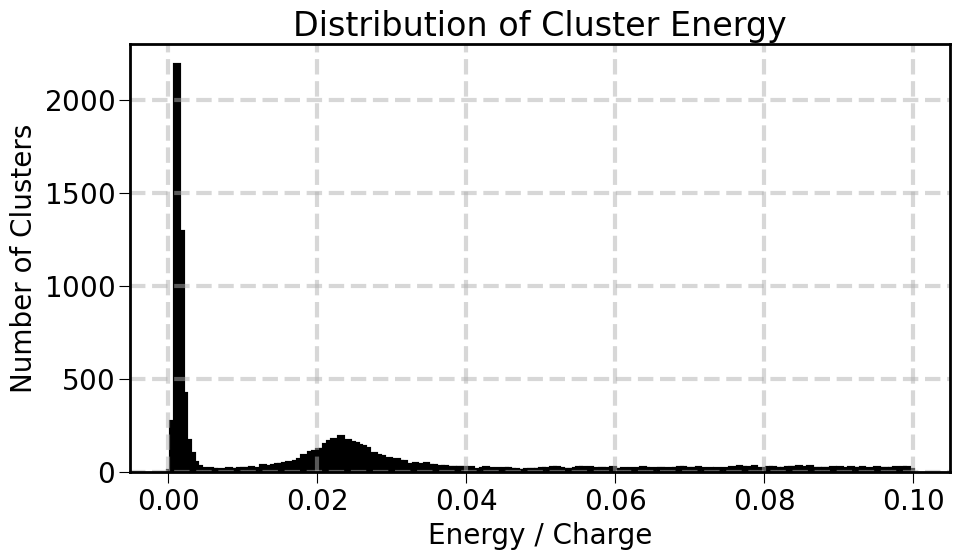

In [30]:
# If your DataFrame is called df_cluster_energy:
values = cluster_energy.values  # or df_cluster_energy.iloc[:, 0].values

plt.figure(figsize=(10, 6))
plt.hist(values, bins=200 , range= (0,0.1), color='steelblue', edgecolor='black')
plt.xlabel('Energy / Charge')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Energy')
plt.grid(True)
plt.tight_layout()
plt.show()

### Energy sum of only cluster with higher energy

In [31]:
# Filter only valid clusters (exclude Scattered or unassigned, e.g. cluster == -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Group by event and cluster, summing energy
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['Ec'].sum()

# Reshape into a DataFrame: rows=events, cols=clusters, values=E sums
cluster_energy_df = cluster_energy.unstack(fill_value=0)

# Find the highest energy per event
max_energy_per_event = cluster_energy_df.max(axis=1)

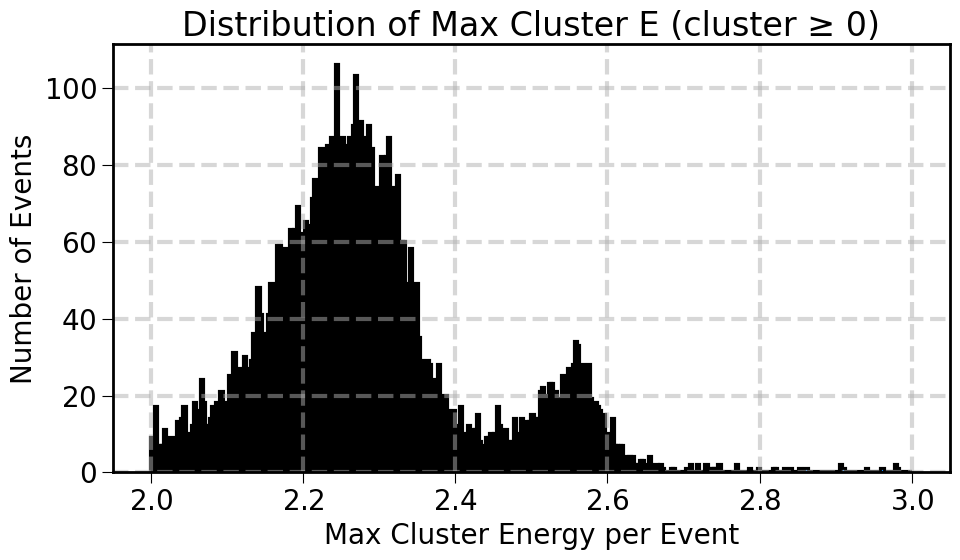

In [32]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(max_energy_per_event.values, bins=350,range = (2.0,3), color='dodgerblue', edgecolor='black')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E (cluster ≥ 0)')
plt.grid(True)
plt.tight_layout()
plt.show()

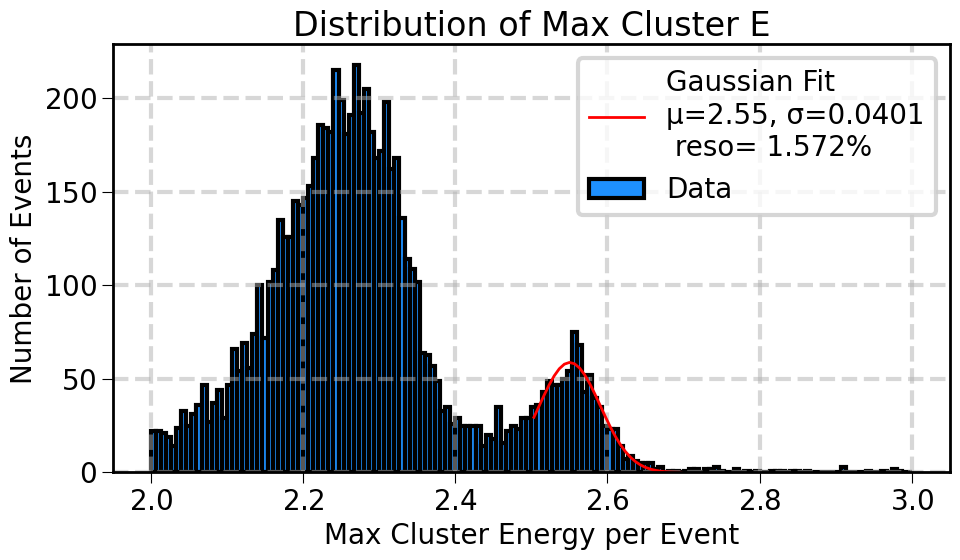

In [33]:
# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

bins = 150
a_range = (2.0,3)

# Histogram as data (not just plot)
data = max_energy_per_event.values
counts, bin_edges = np.histogram(data, bins = bins,range = a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# ---- FITTING RANGE ----
fit_min = 2.5
fit_max = 2.7

# Mask bins within fit range
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# Initial guesses: amplitude, mean, std
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 0.1

# Fit
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[A0, mu0, sigma0])
A, mu, sigma = popt

# ---- PLOTTING ----
plt.figure(figsize=(10, 6))
plt.hist(data, bins = bins,range = a_range, color='dodgerblue', edgecolor='black', label='Data')
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', lw=2, label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.4f}\n reso= {sigma/mu*100:.3f}%')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Energy sum of only cluster with higher energy and ""Scattered""

In [34]:
results = []

# Group by event for efficient processing
for event_id, df_event in df_pe_peak.groupby('event', sort=False):
    # Filter valid clusters
    df_clusters = df_event[df_event['cluster'] >= 0]

    # Get cluster with max Ec
    cluster_sums = df_clusters.groupby('cluster')['Ec'].sum()
    max_cluster_id = cluster_sums.idxmax()
    max_cluster_energy = cluster_sums.max()

    # Z range of that cluster
    df_max_cluster = df_clusters[df_clusters['cluster'] == max_cluster_id]
    z_min = df_max_cluster['Z'].min()
    z_max = df_max_cluster['Z'].max()

    # Get noise (cluster == -1) in that Z range
    df_scattered = df_event[(df_event['cluster'] == -1) & 
                            (df_event['Z'] >= z_min) & (df_event['Z'] <= z_max)]

    scattered_energy = df_scattered['Ec'].sum()

    # Total = main cluster + scattered
    total_energy = max_cluster_energy + scattered_energy

    results.append({
        'event': event_id,
        'max_cluster_id': max_cluster_id,
        'cluster_energy': max_cluster_energy,
        'scattered_energy': scattered_energy,
        'total_energy': total_energy,
        'z_min': z_min,
        'z_max': z_max,
    })

# Create resulting DataFrame
df_total_energy = pd.DataFrame(results)

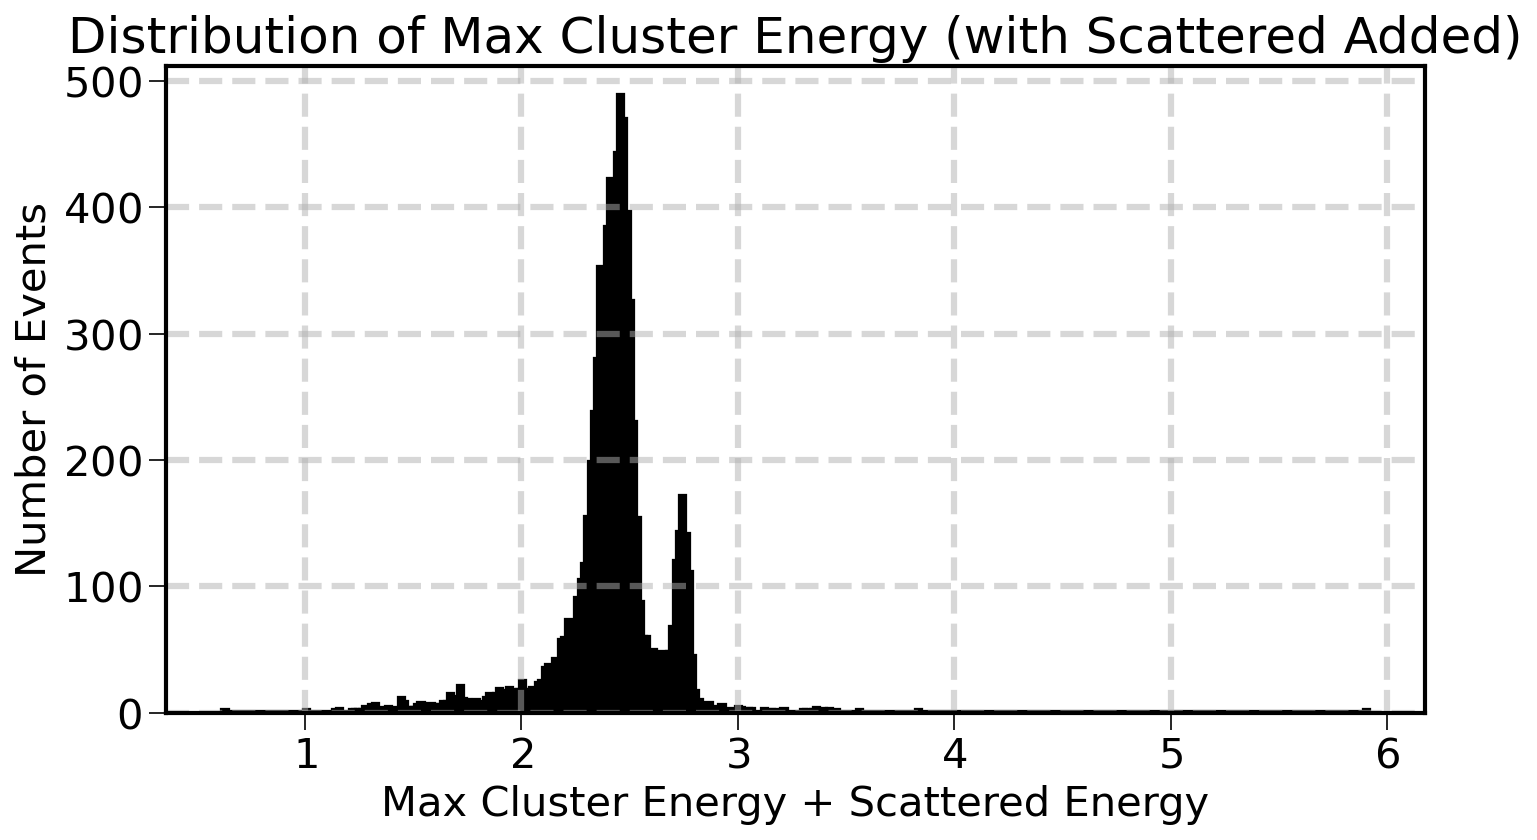

In [35]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(df_total_energy['total_energy'], bins=350, color='steelblue', edgecolor='black')
plt.xlabel('Max Cluster Energy + Scattered Energy')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster Energy (with Scattered Added)')
plt.grid(True)
plt.tight_layout()
plt.show()

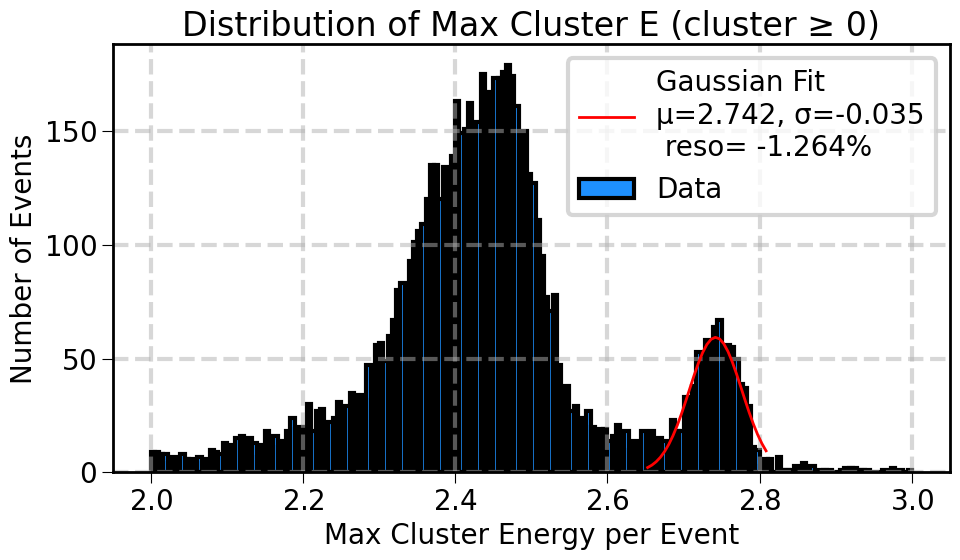

In [36]:
# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

data = df_total_energy['total_energy']

bins=180
a_range = (2.,3)

# Histogram as data (not just plot)
counts, bin_edges = np.histogram(data, bins=bins, range= a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# ---- FITTING RANGE ----
fit_min = 2.65
fit_max = 2.81

# Mask bins within fit range
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# Initial guesses: amplitude, mean, std
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 0.3

# Fit
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[A0, mu0, sigma0])
A, mu, sigma = popt

# ---- PLOTTING ----
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, range= a_range, color='dodgerblue', edgecolor='black', label='Data')
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', lw=2, label=f'Gaussian Fit\nμ={mu:.3f}, σ={sigma:.3f}\n reso= {sigma/mu*100:.3f}%')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E (cluster ≥ 0)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

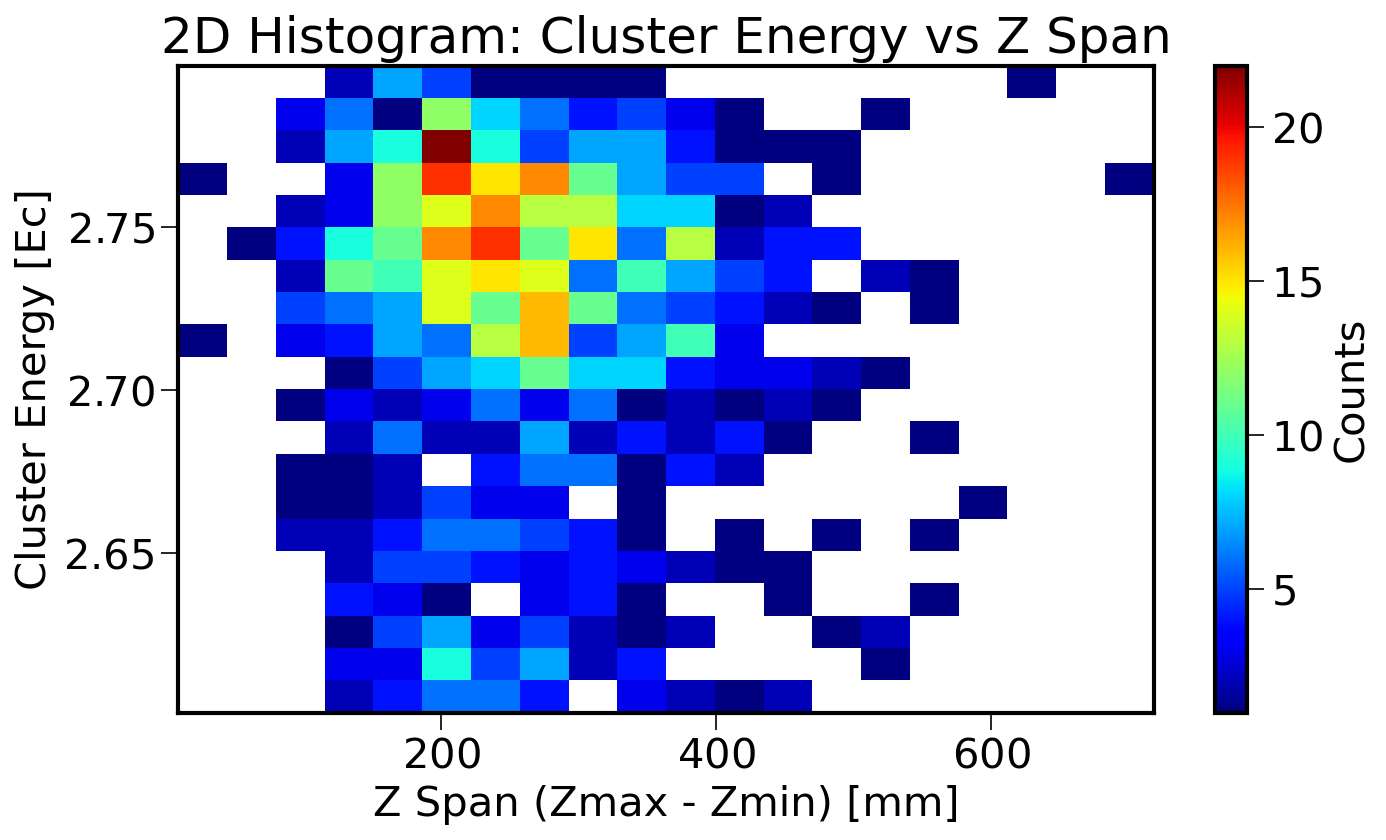

In [37]:
# Filter the data
filtered = df_total_energy[(df_total_energy['total_energy'] > 2.6) & 
                           (df_total_energy['total_energy'] < 2.8)]

# Compute Z span and cluster energy
z_span = filtered['z_max'] - filtered['z_min']
cluster_energy = filtered['total_energy']

# Define bins
x_bins = 20  # Z span
y_bins = 20  # Cluster energy

# Create 2D histogram
counts, xedges, yedges = np.histogram2d(z_span, cluster_energy, bins=[x_bins, y_bins])

# Set zero-count bins to NaN
counts[counts == 0] = np.nan

# Plot
plt.figure(figsize=(10, 6), dpi=150)
mesh = plt.pcolormesh(xedges, yedges, counts.T, cmap='jet', shading='auto')

# Labels and colorbar
plt.xlabel('Z Span (Zmax - Zmin) [mm]')
plt.ylabel('Cluster Energy [Ec]')
plt.title('2D Histogram: Cluster Energy vs Z Span')
plt.colorbar(mesh, label='Counts')
plt.grid(False)
plt.tight_layout()
plt.show()

In [38]:
df_total_energy

event  max_cluster_id  cluster_energy  scattered_energy  total_energy  \
0         869               0        2.045187          0.138101      2.183288   
1        3018               0        2.549074          0.213282      2.762356   
2        5020               0        1.924247          0.088308      2.012555   
3        6889               0        2.242644          0.160698      2.403342   
4        7414               0        2.226707          0.185334      2.412041   
...       ...             ...             ...               ...           ...   
7997  3814512               1        2.065932          0.176121      2.242054   
7998  3815016               0        2.258481          0.172545      2.431027   
7999  3816402               0        2.442077          0.181720      2.623798   
8000  3816689               0        2.112492          0.188854      2.301347   
8001  3816717               1        2.216186          0.225396      2.441583   

           z_min        z_max  
0     508.979750   676.137500  
1     382.938375   577.928625  
2     611.379500   770.993000  
3     527.799875   707.197250  
4     175.541625   382.317000  
...          ...          ...  
7997  581.352000   817.151750  
7998  508.128875   755.387375  
7999  932.810125  1116.164625  
8000   65.777375   312.663000  
8001  898.099750  1269.503000  

[8002 rows x 7 columns]

In [39]:
# Step 1: Filter valid clusters (exclude -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Step 2: Sum E per (event, cluster)
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['E'].sum()

# Step 3: Get the cluster with max E for each event
best_clusters = cluster_energy.groupby('event').idxmax()  # returns (event, cluster) tuples
best_clusters_df = pd.DataFrame(best_clusters.tolist(), columns=['event', 'cluster'])

# Step 4: Merge to get full row indices
df_best = df_pe_peak.merge(best_clusters_df, on=['event', 'cluster'])

# Step 5: Get also Scattered (cluster == -1)
df_Scattered = df_pe_peak[df_pe_peak['cluster'] == -1]

# Step 6: Combine both
df_result = pd.concat([df_best, df_Scattered], ignore_index=True)

In [40]:
df_result

event          time  npeak      Xpeak      Ypeak  nsipm        X  \
0             869  1.752993e+09     32  67.658760  78.877883      1  181.025   
1             869  1.752993e+09     32  67.658760  78.877883      1  196.575   
2             869  1.752993e+09     32  67.658760  78.877883      1  196.575   
3             869  1.752993e+09     32  67.658760  78.877883      1  149.925   
4             869  1.752993e+09     32  67.658760  78.877883      1  165.475   
...           ...           ...    ...        ...        ...    ...      ...   
25268629  3816717  1.753079e+09      7  67.369951  30.842208      1 -435.975   
25268630  3816717  1.753079e+09      7  67.369951  30.842208      1  -96.875   
25268631  3816717  1.753079e+09      7  67.369951  30.842208      1 -281.475   
25268632  3816717  1.753079e+09      7  67.369951  30.842208      1 -359.225   
25268633  3816717  1.753079e+09      7  67.369951  30.842208      1  351.075   

                Y  Xrms  Yrms           Z         Q           E   Qc  \
0         214.825   0.0   0.0   508.97975  7.151848  208.764891 -1.0   
1         183.725   0.0   0.0   508.97975  5.094952  148.723375 -1.0   
2         214.825   0.0   0.0   508.97975  7.373866  215.245665 -1.0   
3         199.275   0.0   0.0   512.76275  6.764262   82.168166 -1.0   
4         183.725   0.0   0.0   512.76275  6.611194   80.308782 -1.0   
...           ...   ...   ...         ...       ...         ...  ...   
25268629  -32.475   0.0   0.0  1269.50300  5.020546   69.629057 -1.0   
25268630  122.525   0.0   0.0  1269.50300  5.301918   73.531356 -1.0   
25268631 -185.975   0.0   0.0  1273.22700  5.106070   29.633648 -1.0   
25268632  137.575   0.0   0.0  1273.22700  5.566214   32.304146 -1.0   
25268633 -356.025   0.0   0.0  1273.22700  6.098174   35.391438 -1.0   

                Ec  track_id   Ep  cluster  
0         0.001092        -1 -1.0        0  
1         0.000770        -1 -1.0        0  
2         0.001138        -1 -1.0        0  
3         0.000427        -1 -1.0        0  
4         0.000415        -1 -1.0        0  
...            ...       ...  ...      ...  
25268629  0.000439        -1 -1.0       -1  
25268630  0.000393        -1 -1.0       -1  
25268631  0.000163        -1 -1.0       -1  
25268632  0.000187        -1 -1.0       -1  
25268633       NaN        -1 -1.0       -1  

[25268634 rows x 18 columns]

In [41]:
slice_results = []

for event_id, df_event in df_pe_peak.groupby('event'):
    df_c0 = df_event[df_event['cluster'] == 0]

    z_min = df_c0['Z'].min()
    z_max = df_c0['Z'].max()

    # Define Z slice edges
    bins = np.arange(z_min, z_max + 40, 40)

    df_event = df_event.copy()
    df_event['z_slice'] = np.digitize(df_event['Z'], bins) - 1

    for slice_idx in range(len(bins) - 1):
        df_slice = df_event[df_event['z_slice'] == slice_idx]

        total_Q = df_slice['Q'].sum()
        Scattered_points = df_slice[df_slice['cluster'] == -1]
        Scattered_count = len(Scattered_points)
        Scattered_Q = Scattered_points['Q'].sum()

        slice_results.append({
            'event': event_id,
            'slice_idx': slice_idx,
            'z_start': bins[slice_idx],
            'z_end': bins[slice_idx + 1],
            'total_Q': total_Q,
            'Scattered_count': Scattered_count,
            'Scattered_Q': Scattered_Q
        })

# Create DataFrame with results
df_slices = pd.DataFrame(slice_results)

In [42]:
df_slices

event  slice_idx     z_start       z_end       total_Q  \
0          534          0  760.192125  800.192125  12344.283330   
1          534          1  800.192125  840.192125   3104.768094   
2          534          2  840.192125  880.192125   1274.484096   
3          534          3  880.192125  920.192125    929.088584   
4          534          4  920.192125  960.192125  11764.826510   
...        ...        ...         ...         ...           ...   
38926  3816689          3  185.777375  225.777375   4888.048163   
38927  3816689          4  225.777375  265.777375   3223.399659   
38928  3816689          5  265.777375  305.777375   7222.222587   
38929  3816689          6  305.777375  345.777375    734.865758   
38930  3816717          0  533.526813  573.526813   3380.614517   

       Scattered_count  Scattered_Q  
0                  140   841.929936  
1                   48   290.268172  
2                   33   206.883273  
3                   51   308.074191  
4                  119   737.629370  
...                ...          ...  
38926               64   409.728489  
38927               40   236.079846  
38928               72   437.039782  
38929               30   185.932104  
38930               52   307.649826  

[38931 rows x 7 columns]

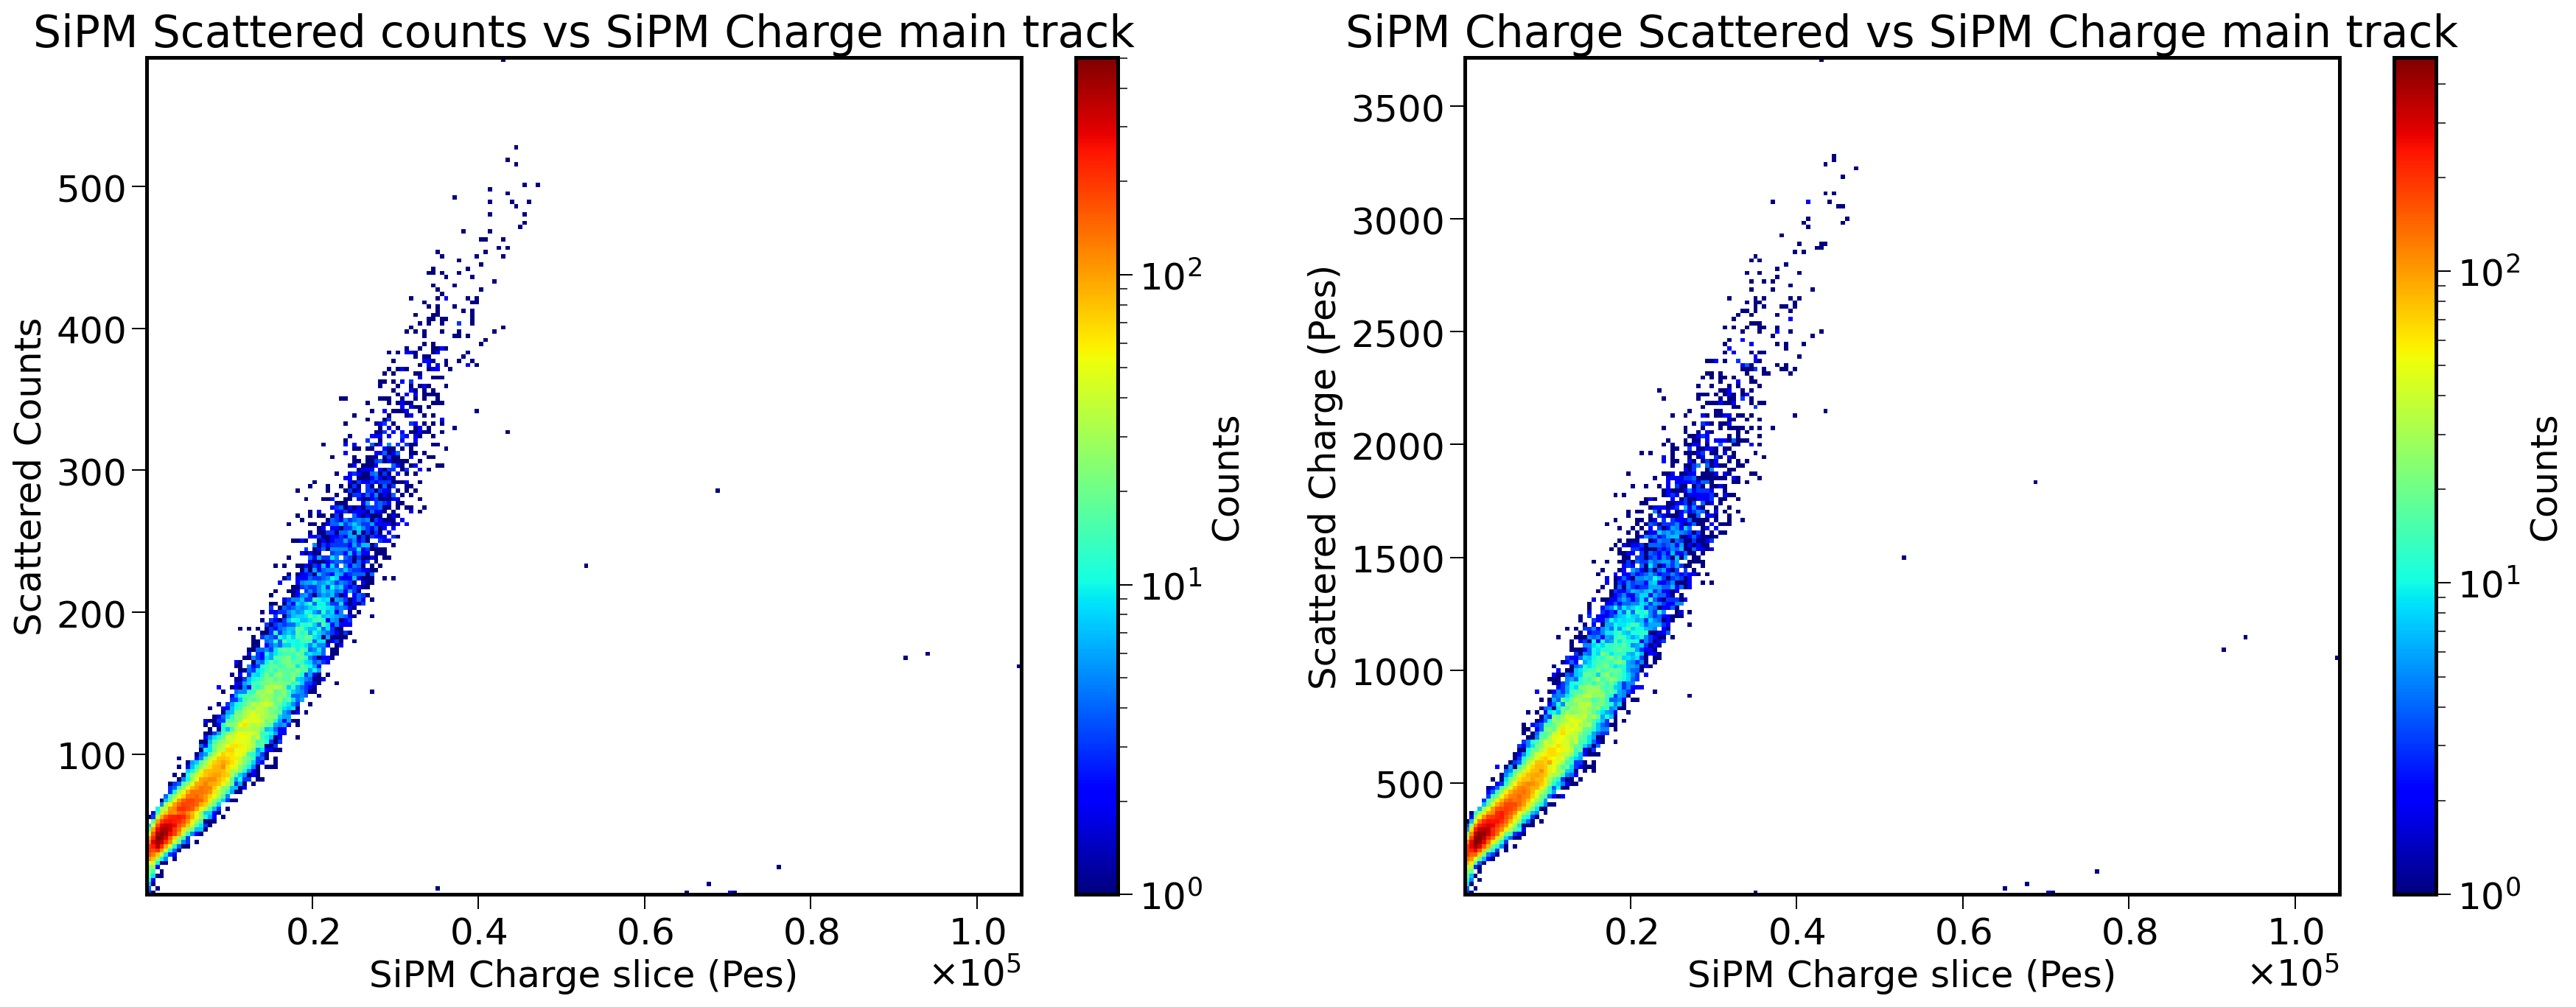

In [43]:
# Get data
x1 = df_slices['Scattered_count']
y1 = df_slices['total_Q']

x2 = df_slices['Scattered_Q']
y2 = df_slices['total_Q']

# --- Compute histogram 1 ---
counts1, xedges1, yedges1 = np.histogram2d(y1, x1, bins=[200, 200])
counts1[counts1 == 0] = np.nan  # set 0s to NaN

# --- Compute histogram 2 ---
counts2, xedges2, yedges2 = np.histogram2d(y2, x2, bins=[200, 200])
counts2[counts2 == 0] = np.nan  # set 0s to NaN

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=180)

# Plot 1: Scattered count vs total_Q
mesh1 = axes[0].pcolormesh(xedges1, yedges1, counts1.T, cmap='jet', shading='auto', norm=LogNorm())
fig.colorbar(mesh1, ax=axes[0], label='Counts')
axes[0].set_title('SiPM Scattered counts vs SiPM Charge main track')
axes[0].set_xlabel('SiPM Charge slice (Pes)')
axes[0].set_ylabel('Scattered Counts')
axes[0].grid(False)

# Plot 2: Scattered Q vs total_Q
mesh2 = axes[1].pcolormesh(xedges2, yedges2, counts2.T, cmap='jet', shading='auto', norm=LogNorm())
fig.colorbar(mesh2, ax=axes[1], label='Counts')
axes[1].set_title('SiPM Charge Scattered vs SiPM Charge main track')
axes[1].set_xlabel('SiPM Charge slice (Pes)')
axes[1].set_ylabel('Scattered Charge (Pes)')
axes[1].grid(False)

plt.tight_layout()
plt.show()

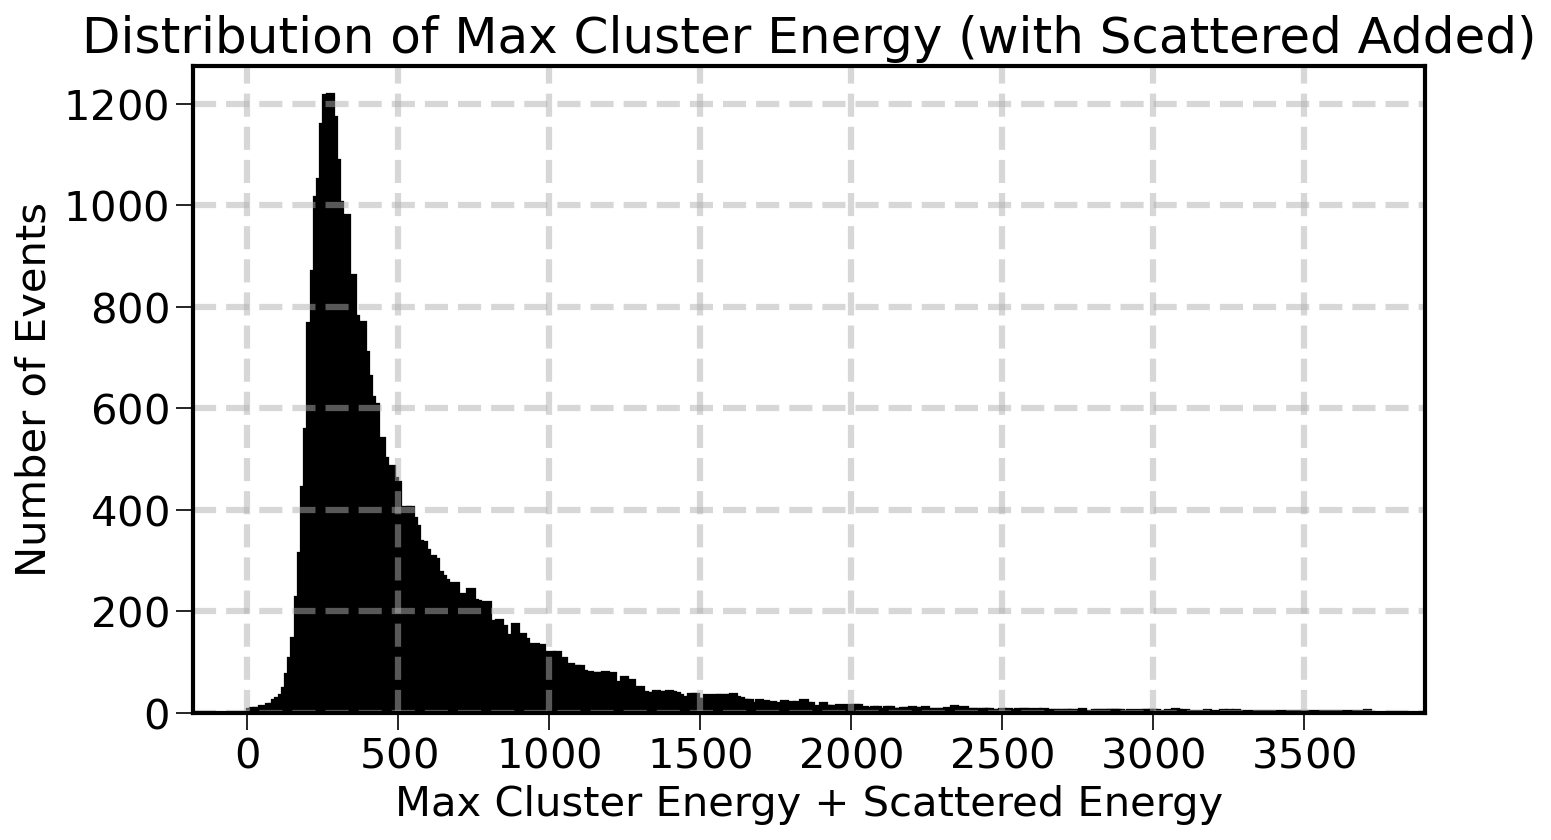

In [49]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(df_slices['Scattered_Q'], bins=350, color='steelblue', edgecolor='black')
plt.xlabel('Max Cluster Energy + Scattered Energy')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster Energy (with Scattered Added)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
df_pe_peak

event          time  npeak      Xpeak      Ypeak  nsipm        X  \
0             869  1.752993e+09     32  67.658760  78.877883      1 -482.625   
1             869  1.752993e+09     32  67.658760  78.877883      1  -19.125   
2             869  1.752993e+09     32  67.658760  78.877883      1  351.075   
3             869  1.752993e+09     32  67.658760  78.877883      1 -126.975   
4             869  1.752993e+09     32  67.658760  78.877883      1   -3.575   
...           ...           ...    ...        ...        ...    ...      ...   
27772431  3816717  1.753079e+09      7  67.369951  30.842208      1   73.175   
27772432  3816717  1.753079e+09      7  67.369951  30.842208      1   88.725   
27772433  3816717  1.753079e+09      7  67.369951  30.842208      1 -281.475   
27772434  3816717  1.753079e+09      7  67.369951  30.842208      1 -359.225   
27772435  3816717  1.753079e+09      7  67.369951  30.842208      1  351.075   

                Y  Xrms  Yrms            Z         Q          E   Qc  \
0         260.975   0.0   0.0   484.545750  5.194547   0.699879 -1.0   
1        -433.275   0.0   0.0   484.545750  6.715086   0.904746 -1.0   
2        -217.075   0.0   0.0   484.545750  5.698934   0.767836 -1.0   
3         399.425   0.0   0.0   489.781875  5.224109   0.156531 -1.0   
4         414.975   0.0   0.0   489.781875  8.781216   0.263113 -1.0   
...           ...   ...   ...          ...       ...        ...  ...   
27772431   60.325   0.0   0.0  1269.503000  5.945141  82.452099 -1.0   
27772432   13.675   0.0   0.0  1269.503000  6.643796  92.141622 -1.0   
27772433 -185.975   0.0   0.0  1273.227000  5.106070  29.633648 -1.0   
27772434  137.575   0.0   0.0  1273.227000  5.566214  32.304146 -1.0   
27772435 -356.025   0.0   0.0  1273.227000  6.098174  35.391438 -1.0   

                    Ec  track_id   Ep  cluster  
0                  NaN        -1 -1.0       -1  
1         5.550780e-06        -1 -1.0       -1  
2         4.310546e-06        -1 -1.0       -1  
3         9.188695e-07        -1 -1.0       -1  
4         1.543880e-06        -1 -1.0       -1  
...                ...       ...  ...      ...  
27772431  4.313831e-04        -1 -1.0        1  
27772432  4.869077e-04        -1 -1.0        1  
27772433  1.633023e-04        -1 -1.0       -1  
27772434  1.868839e-04        -1 -1.0       -1  
27772435           NaN        -1 -1.0       -1  

[26894627 rows x 18 columns]

In [45]:
kr_map = af.load_kr_map('../db/kr_maps/average_map_15614_15615.npz')

In [46]:
df_pe_peak = af.correct_Hits(df_pe_peak,kr_map)

AttributeError: module 'analysis_functions' has no attribute 'correct_Hits'

In [ ]:
df_pe_peak

# Analysis not counting scattered energy

In [ ]:
# Filter only valid clusters (exclude Scattered or unassigned, e.g. cluster == -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Group by event and cluster, summing energy
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['Ec'].sum()

# Reshape into a DataFrame: rows=events, cols=clusters, values=E sums
cluster_energy_df = cluster_energy.unstack(fill_value=0)

# Find the highest energy per event
max_energy_per_event = cluster_energy_df.max(axis=1)

In [ ]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(max_energy_per_event.values, bins=350, color='dodgerblue', edgecolor='black')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E (cluster ≥ 0)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Define functions ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, B, lamb):
    return B * np.exp(-lamb * x)

def gauss_plus_exp(x, A, mu, sigma, B, lamb):
    return gaussian(x, A, mu, sigma) + exponential(x, B, lamb)

# --- Histogram parameters ---
bins = 150
a_range = (4.5e5, 5.5e5)

# --- Histogram data ---
data = max_energy_per_event.values
counts, bin_edges = np.histogram(data, bins=bins, range=a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# --- Fit range mask ---
fit_min = 4.8e5
fit_max = 5.2e5
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# --- Initial guesses ---
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 2000
B0 = y_fit.min()
lamb0 = 1e-6

# --- Fit ---
p0 = [A0, mu0, sigma0, B0, lamb0]
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf])  # optional: constrain to positive values

popt, pcov = curve_fit(gauss_plus_exp, x_fit, y_fit, p0=p0, bounds=bounds)
A, mu, sigma, B, lamb = popt

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, range=a_range, color='dodgerblue', edgecolor='blue', label='Data')

x_plot = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_plot, gauss_plus_exp(x_plot, *popt), 'r-', lw=2, label=f'Gaussian + Exp Fit\nμ={mu:.2f}, σ={sigma:.2f}, Reso={sigma/mu*100:.3f}%')
plt.plot(x_plot, gaussian(x_plot, A, mu, sigma), 'g--', lw=1.5, label='Gaussian component')
plt.plot(x_plot, exponential(x_plot, B, lamb), 'k--', lw=1.5, label='Exponential component')

plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
results = []

# Group by event for efficient processing
for event_id, df_event in df_pe_peak.groupby('event', sort=False):
    # Filter valid clusters
    df_clusters = df_event[df_event['cluster'] >= 0]

    # Get cluster with max Ec
    cluster_sums = df_clusters.groupby('cluster')['Ec'].sum()
    if cluster_sums.empty:
        continue
        
    max_cluster_id = cluster_sums.idxmax()
    max_cluster_energy = cluster_sums.max()

    # Z range of that cluster
    df_max_cluster = df_clusters[df_clusters['cluster'] == max_cluster_id]
    z_min = df_max_cluster['Z'].min()
    z_max = df_max_cluster['Z'].max()

    # Get noise (cluster == -1) in that Z range
    df_scattered = df_event[(df_event['cluster'] == -1) & 
                            (df_event['Z'] >= z_min) & (df_event['Z'] <= z_max)]

    scattered_energy = df_scattered['Ec'].sum()

    # Total = main cluster + scattered
    total_energy = max_cluster_energy + scattered_energy

    results.append({
        'event': event_id,
        'max_cluster_id': max_cluster_id,
        'cluster_energy': max_cluster_energy,
        'scattered_energy': scattered_energy,
        'total_energy': total_energy,
        'z_min': z_min,
        'z_max': z_max,
    })

# Create resulting DataFrame
df_total_energy = pd.DataFrame(results)

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(df_total_energy['total_energy'], bins=350, color='steelblue', edgecolor='black')
plt.xlabel('Max Cluster Energy + Scattered Energy')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster Energy (with Scattered Added)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Define functions ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, B, lamb):
    return B * np.exp(-lamb * x)

def gauss_plus_exp(x, A, mu, sigma, B, lamb):
    return gaussian(x, A, mu, sigma) + exponential(x, B, lamb)

# --- Histogram parameters ---
bins = 100
a_range = (4e5, 6e5)

# --- Histogram data ---
data = df_total_energy['total_energy'].values
counts, bin_edges = np.histogram(data, bins=bins, range=a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# --- Fit range mask ---
fit_min = 5e5
fit_max = 5.5e5
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# --- Initial guesses ---
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 2000
B0 = y_fit.min()
lamb0 = 1e-6

# --- Fit ---
p0 = [A0, mu0, sigma0, B0, lamb0]
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf])  # optional: constrain to positive values

popt, pcov = curve_fit(gauss_plus_exp, x_fit, y_fit, p0=p0, bounds=bounds)
A, mu, sigma, B, lamb = popt

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, range=a_range, color='dodgerblue', edgecolor='blue', label='Data')

x_plot = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_plot, gauss_plus_exp(x_plot, *popt), 'r-', lw=2, label=f'Gaussian + Exp Fit\nμ={mu:.2f}, σ={sigma:.2f}, Reso={sigma/mu*100:.3f}%')
plt.plot(x_plot, gaussian(x_plot, A, mu, sigma), 'g--', lw=1.5, label='Gaussian component')
plt.plot(x_plot, exponential(x_plot, B, lamb), 'k--', lw=1.5, label='Exponential component')

plt.xlabel('E corrected (Pes)')
plt.ylabel('Counts')
plt.grid(True)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()